# Librairies

In [74]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingRegressor
import shap

pd.set_option('display.max_columns', None)

# Importation des données

In [75]:
# File path

file_path = r"C:\Users\jerem\OneDrive - De Vinci\Documents\ISUP\M2 ISUP\Machine Learning\Projet\sampled_data.csv"
df = pd.read_csv(file_path, sep=',', on_bad_lines='skip', encoding='ISO-8859-1')

In [76]:
df

,cod_apo,COD_MODELO,ANO_MODELO,COD_TARIF,REGIAO,IS_CASCO,IS_RCDMAT,IS_RCDC,IS_RCDMOR,INICIO_VIG,SEXO,DATA_NASC,TEMPO_HAB,UTILIZACAO,AGE,COBERTURA,EVENTO,INDENIZ,VAL_SALVAD,VAL_RESS,D_AVI,D_OCORR,CAUSA,D_NASC,CEP,Cause,TypeSinistre,codeTarif,Region,TypeCouverture
0,15848249.0,001378-1,2017,10,18,41781.0,50000.0,50000.0,0.0,20200815,M,1965-11-17,0,0,59,2,1,38949,0,0,20200817,20200814,2,19651117,21635000,Vol,Coque (Casco),VÃÂ©hicules de tourisme nationaux,RJ - Met. do Rio de Janeiro,Couverture incendie et vol
1,9720865.0,014041-4,2003,10,11,17000.0,75000.0,75000.0,0.0,20201028,F,1990-10-21,0,2,34,1,1,221,0,0,20201126,20201123,9,19901021,3648090,Autres,Coque (Casco),VÃÂ©hicules de tourisme nationaux,SP - Met. de SÃÂ£o Paulo,Couverture complÃÂ¨te
2,8657518.0,004202-1,2002,10,11,10015.0,50000.0,50000.0,0.0,20200511,F,1978-08-17,0,2,46,1,1,268,0,0,20210104,20201230,9,19780817,8330285,Autres,Coque (Casco),VÃÂ©hicules de tourisme nationaux,SP - Met. de SÃÂ£o Paulo,Couverture complÃÂ¨te
3,194491.0,811101-4,2012,30,22,6111.0,10000.0,10000.0,0.0,20201008,M,1998-01-02,0,1,26,1,2,2411,0,0,20201026,20201023,4,19980102,49400000,Collision partielle,ResponsabilitÃÂ© Civile Facultative de VÃÂ©h...,"Bicyclettes motorisÃÂ©es, motos, scooters ave...",SE - Sergipe,Couverture complÃÂ¨te
4,13994680.0,004121-1,2002,10,11,10010.0,100000.0,100000.0,0.0,20200608,F,1962-07-12,0,2,62,1,8,85,0,0,20200817,20200816,7,19620712,4288080,Assistance 24 heures,Autres,VÃÂ©hicules de tourisme nationaux,SP - Met. de SÃÂ£o Paulo,Couverture complÃÂ¨te
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,12989144.0,002175-0,2019,10,39,62312.0,50000.0,100000.0,0.0,20200609,F,1980-06-09,0,2,44,1,8,97,0,0,20201209,20201208,7,19800609,74810130,Assistance 24 heures,Autres,VÃÂ©hicules de tourisme nationaux,GO - GoiÃÂ¡s,Couverture complÃÂ¨te
299996,4577164.0,008040-3,2003,10,27,17613.0,100000.0,100000.0,0.0,20200806,F,1982-10-19,0,2,42,1,1,80,0,0,20200720,20200720,9,19821019,60841000,Autres,Coque (Casco),VÃÂ©hicules de tourisme nationaux,CE - CearÃÂ¡,Couverture complÃÂ¨te
299997,7301086.0,003402-9,2015,11,22,0.0,100000.0,100000.0,10000.0,20200915,M,1960-02-19,0,2,64,4,2,6200,0,0,20201014,20201014,9,19600219,49036070,Autres,ResponsabilitÃÂ© Civile Facultative de VÃÂ©h...,VÃÂ©hicules de tourisme importÃÂ©s,SE - Sergipe,"Indemnisation intÃÂ©grale, collision et vol"
299998,4771877.0,001269-6,2010,10,4,18995.0,75000.0,75000.0,0.0,20190706,M,1943-09-08,0,2,81,1,1,1594,0,0,20200612,20200610,4,19430908,89935000,Collision partielle,Coque (Casco),VÃÂ©hicules de tourisme nationaux,SC - Oeste,Couverture complÃÂ¨te


# Nettoyage

In [77]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['IS_CASCO','TEMPO_HAB',  'UTILIZACAO','IS_RCDMAT', 'IS_RCDC', 'IS_RCDMOR', 'INICIO_VIG',"VAL_SALVAD",'VAL_RESS','D_AVI','D_OCORR', 'cod_apo', "CEP", "Cause", "TypeSinistre",	"codeTarif", "Region",	"TypeCouverture", "D_NASC", "DATA_NASC"]

# Suppression des colonnes
df = df.drop(columns=colonnes_a_supprimer)

In [78]:
df['INDENIZ'] = pd.to_numeric(df['INDENIZ'], errors='coerce')
df['SEXO'] = df['SEXO'].astype(str)
df = df[df['SEXO'] != '0']
# Calculer le 99ème quantile pour la colonne INDENIZ
quantile_99 = df['INDENIZ'].quantile(0.99)
# Filtrer le DataFrame pour ne conserver que les valeurs inférieures ou égales au 99ème quantile
df= df[df['INDENIZ'] <= quantile_99]

# Afficher un résumé des données filtrées

df= df[df['AGE'] <= 100]
df = df[df['AGE'] > 16]

df['INDENIZ'] = pd.to_numeric(df['INDENIZ'], errors='coerce')

# Définir les variables explicatives et la cible
target = df['INDENIZ']  # Variable cible (coût des sinistres)
features = df.drop(columns=['INDENIZ'])  # Supprimer la cible des explicatives

## Division par classe d'âge et d'ancienneté de vehicule

In [79]:
# Classer les âges par tranche de 5 ans
df['AGE_Group'] = pd.cut(df['AGE'], bins=range(0, df['AGE'].max() + 5, 5), right=False)

# Classer les années de voiture par tranche de 3 ans
min_year = df['ANO_MODELO'].min()
max_year = df['ANO_MODELO'].max()
df['ANO_MODELO_Class'] = pd.cut(df['ANO_MODELO'], bins=range(min_year, max_year + 3, 3), right=False)

# Afficher les premières lignes pour vérifier
print(df[['AGE', 'AGE_Group', 'ANO_MODELO', 'ANO_MODELO_Class']].head())

   AGE AGE_Group  ANO_MODELO ANO_MODELO_Class
0   59  [55, 60)        2017     [2015, 2018)
1   34  [30, 35)        2003     [2003, 2006)
2   46  [45, 50)        2002     [2000, 2003)
3   26  [25, 30)        2012     [2012, 2015)
4   62  [60, 65)        2002     [2000, 2003)


## Traitement des valeurs manquantes

In [80]:
# Vérifier si des valeurs manquantes existent dans le DataFrame
missing_values_summary = df.isnull().sum()

# Filtrer pour afficher uniquement les colonnes avec des valeurs manquantes
missing_columns = missing_values_summary[missing_values_summary > 0]

missing_columns

AGE_Group              2
ANO_MODELO_Class    1487
dtype: int64

In [81]:
# Supprimer les lignes contenant des valeurs manquantes dans AGE_Group et ANO_MODELO_Class
df = df.dropna(subset=['AGE_Group', 'ANO_MODELO_Class'])

# Vérifier à nouveau les valeurs manquantes pour confirmer
missing_values_summary_after = df.isnull().sum()
print(missing_values_summary_after)

COD_MODELO          0
ANO_MODELO          0
COD_TARIF           0
REGIAO              0
SEXO                0
AGE                 0
COBERTURA           0
EVENTO              0
INDENIZ             0
CAUSA               0
AGE_Group           0
ANO_MODELO_Class    0
dtype: int64


In [82]:
# Supprimer les colonnes ANO_MODELO et AGE
df = df.drop(columns=['ANO_MODELO', 'AGE'])

# Convertir toutes les colonnes sauf 'INDENIZ' en str
columns_to_convert = [col for col in df.columns if col != 'INDENIZ']
df[columns_to_convert] = df[columns_to_convert].astype(str)

# Vérifier les types de données après conversion
print(df.dtypes)

COD_MODELO           object
COD_TARIF            object
REGIAO               object
SEXO                 object
COBERTURA            object
EVENTO               object
INDENIZ             float64
CAUSA                object
AGE_Group            object
ANO_MODELO_Class     object
dtype: object


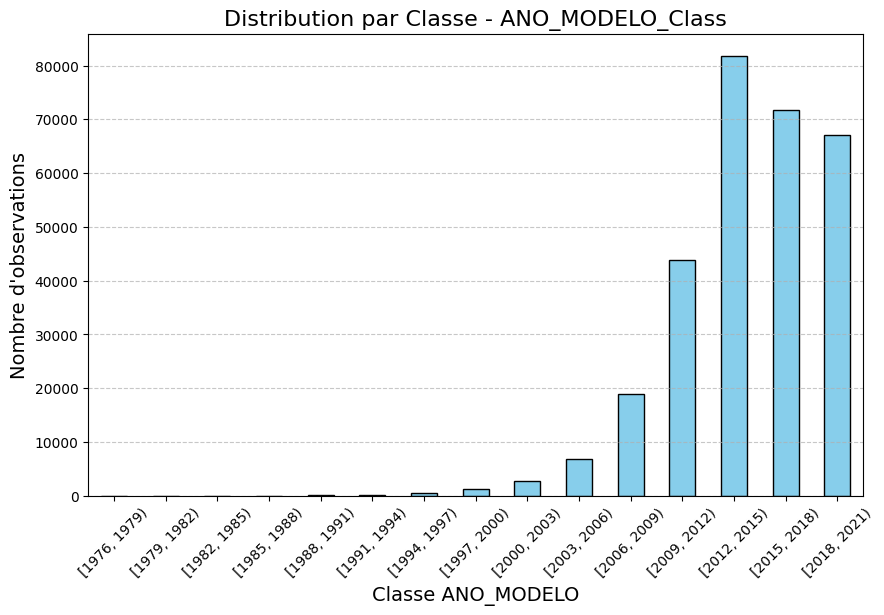

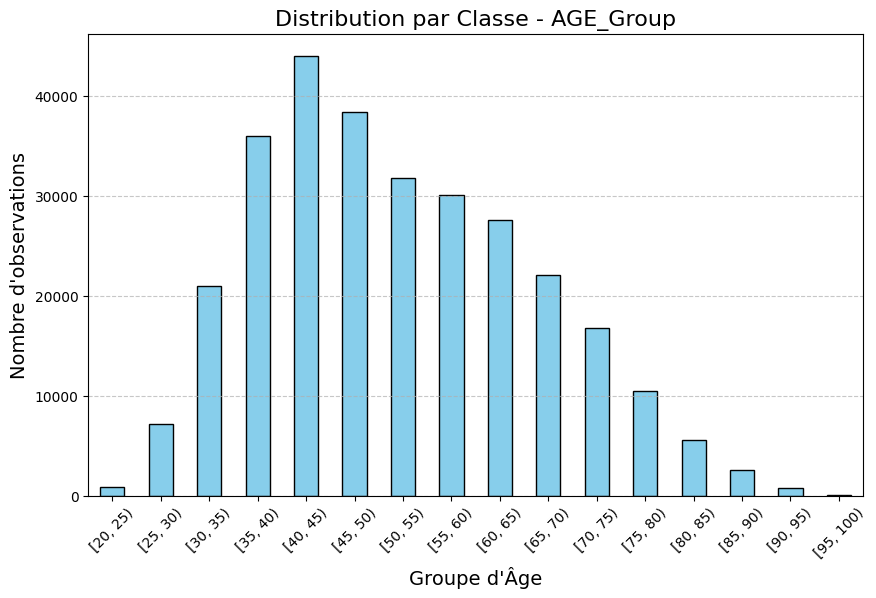

In [83]:
# Vérification des colonnes nécessaires
if 'ANO_MODELO_Class' in df.columns and 'AGE_Group' in df.columns:
    # Histogramme pour ANO_MODELO_Class
    plt.figure(figsize=(10, 6))
    df['ANO_MODELO_Class'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Distribution par Classe - ANO_MODELO_Class", fontsize=16)
    plt.xlabel("Classe ANO_MODELO", fontsize=14)
    plt.ylabel("Nombre d'observations", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Histogramme pour AGE_Group
    plt.figure(figsize=(10, 6))
    df['AGE_Group'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Distribution par Classe - AGE_Group", fontsize=16)
    plt.xlabel("Groupe d'Âge", fontsize=14)
    plt.ylabel("Nombre d'observations", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Les colonnes 'ANO_MODELO_Class' et/ou 'AGE_Group' ne sont pas disponibles dans le DataFrame.")

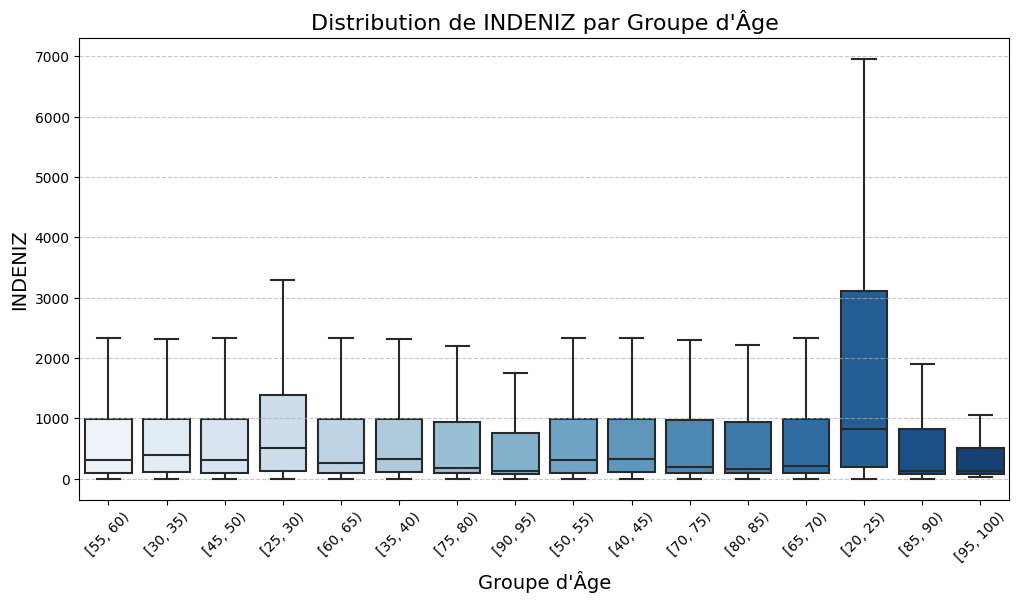

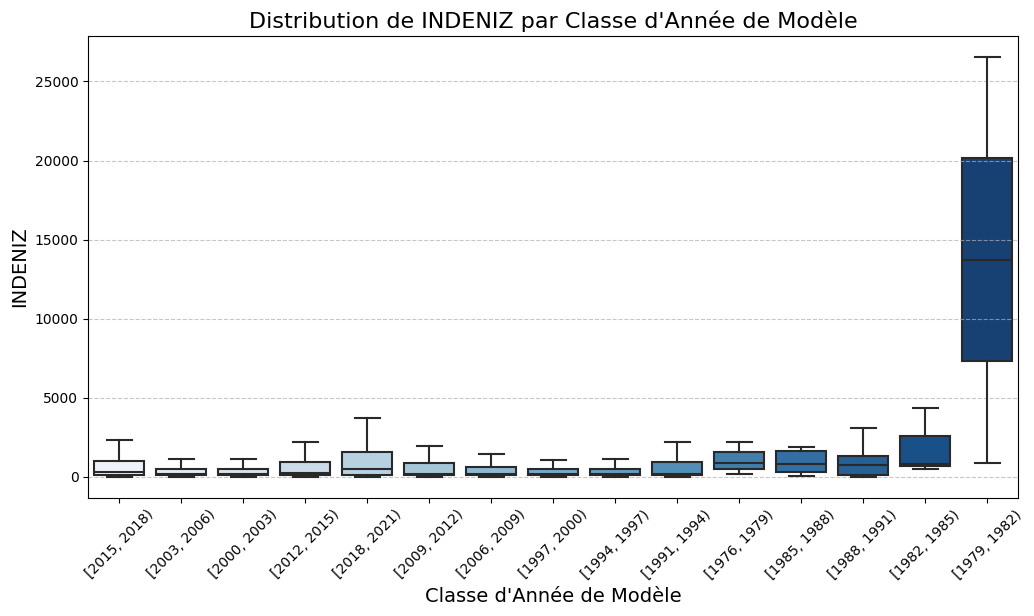

In [84]:
# Vérification des colonnes nécessaires
if 'AGE_Group' in df.columns and 'ANO_MODELO_Class' in df.columns and 'INDENIZ' in df.columns:
    # Boxplot pour AGE_Group
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='AGE_Group', y='INDENIZ', showfliers=False, palette="Blues")
    plt.title("Distribution de INDENIZ par Groupe d'Âge", fontsize=16)
    plt.xlabel("Groupe d'Âge", fontsize=14)
    plt.ylabel("INDENIZ", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Boxplot pour ANO_MODELO_Class
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='ANO_MODELO_Class', y='INDENIZ', showfliers=False, palette="Blues")
    plt.title("Distribution de INDENIZ par Classe d'Année de Modèle", fontsize=16)
    plt.xlabel("Classe d'Année de Modèle", fontsize=14)
    plt.ylabel("INDENIZ", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Les colonnes 'AGE_Group', 'ANO_MODELO_Class' et/ou 'INDENIZ' ne sont pas disponibles dans le DataFrame.")

In [85]:
df.dtypes

COD_MODELO           object
COD_TARIF            object
REGIAO               object
SEXO                 object
COBERTURA            object
EVENTO               object
INDENIZ             float64
CAUSA                object
AGE_Group            object
ANO_MODELO_Class     object
dtype: object

In [86]:
# Define target and features
target = 'INDENIZ'  # Replace with your target column name
features = df.drop(columns=[target])  # All columns except target

# Identify numerical and categorical columns
num_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features, df[target], test_size=0.2, random_state=42)

# RandomForest

Scores MSE négatifs par pli : [-12549465.43656843 -13375317.47294361 -13056786.21673835
 -12376609.23082506 -12994373.32230236]
MSE moyen : 12870510.33587556
MAE : 1313.47
RMSE : 3550.11
R² : 0.50
MSE : 12603294.98
Déviance : 1487138394752.78
AIC : 973189.96


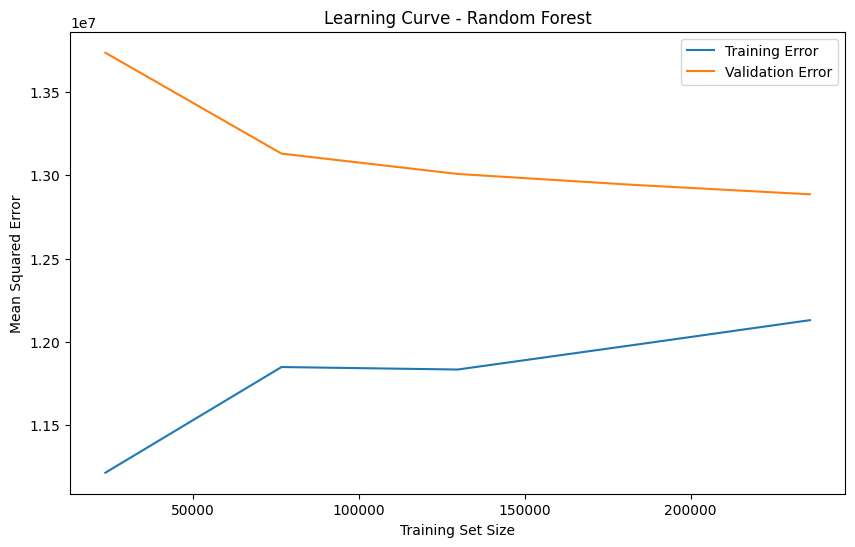

In [87]:
# Define pipelines for numerical and categorical columns
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

# Define the full pipeline with Random Forest
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42))
])

# Perform K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_pipeline, features, df[target], cv=kf, scoring='neg_mean_squared_error')

# Print CV results
print("Scores MSE négatifs par pli :", cv_scores)
print("MSE moyen :", -cv_scores.mean())

# Fit the model pipeline on the training set
model_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_pipeline.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Approximate deviance as 2 * sum of squared residuals
deviance = 2 * mse * len(y_test)

# Approximate AIC (without classical likelihood)
n_params = len(model_pipeline.named_steps['model'].feature_importances_)
aic = len(y_test) * np.log(mse) + 2 * n_params

# Print metrics
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.2f}")
print(f"MSE : {mse:.2f}")
print(f"Déviance : {deviance:.2f}")
print(f"AIC : {aic:.2f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model_pipeline, features, df[target], cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Calculate mean train and test scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, test_scores_mean, label="Validation Error")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.show()

Les 10 caractéristiques les plus importantes :
                            Feature  Importance
4267                        CAUSA_5    0.317262
4266                        CAUSA_4    0.192749
4265                        CAUSA_3    0.156370
4263                        CAUSA_1    0.087735
4256                       EVENTO_2    0.037652
4252                    COBERTURA_4    0.034943
4255                       EVENTO_1    0.022904
4181                   COD_TARIF_10    0.012321
4264                        CAUSA_2    0.011811
4300  ANO_MODELO_Class_[2015, 2018)    0.007618


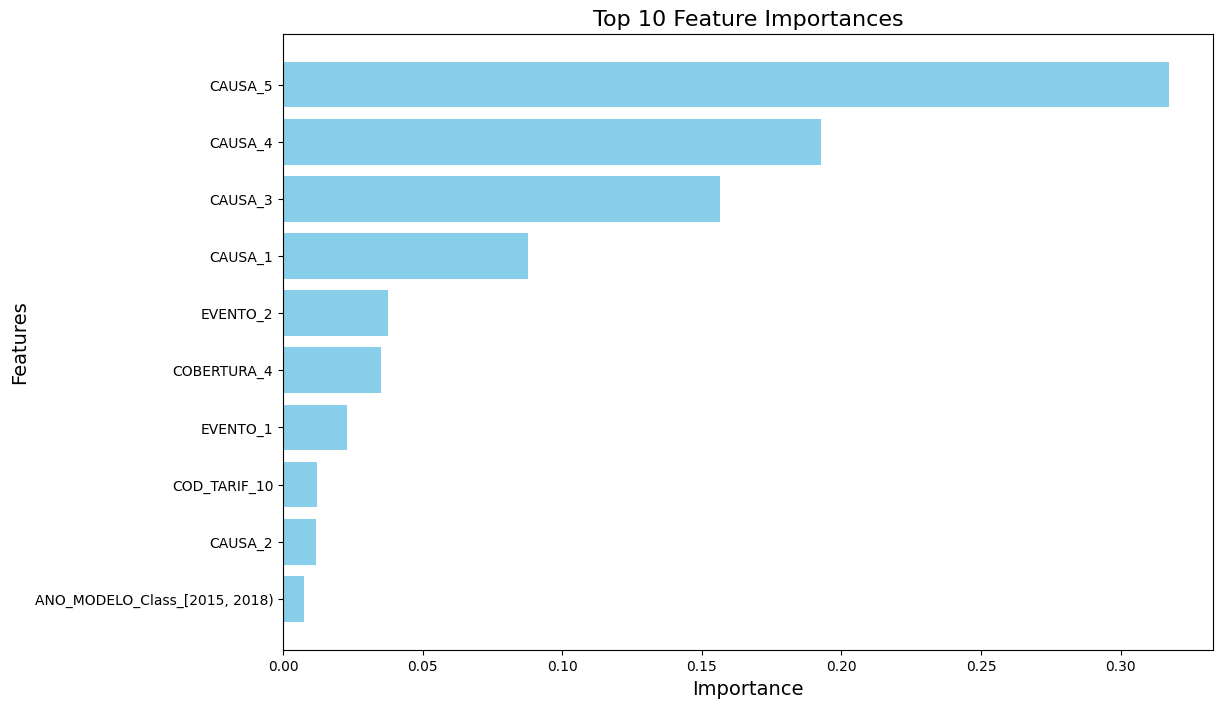

In [90]:
# Ajuster le pipeline avec les données d'entraînement
model_pipeline.fit(X_train, y_train)

# Obtenir les noms des colonnes après transformation pour les catégories
encoded_features = model_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols)

# Obtenir les importances des caractéristiques
importances = model_pipeline.named_steps['model'].feature_importances_

# Vérifier si les dimensions correspondent
if len(encoded_features) == len(importances):
    feature_importances = pd.DataFrame({
        'Feature': encoded_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Afficher les 10 caractéristiques les plus importantes
    print("Les 10 caractéristiques les plus importantes :")
    print(feature_importances.head(10))

    # Visualisation
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
    plt.title('Top 10 Feature Importances', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Erreur : Les dimensions des colonnes transformées et des importances ne correspondent pas.")

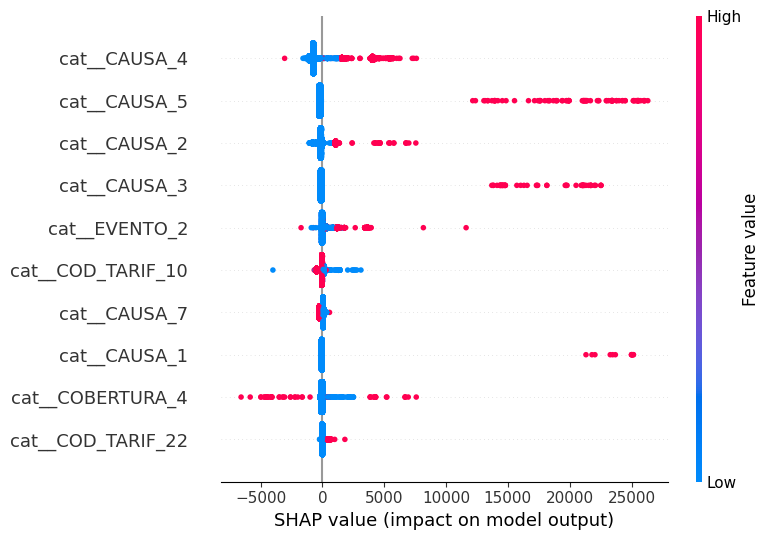

In [93]:
# Étape 1 : Transformer les données d'entrée avec le pipeline
X_test_transformed = model_pipeline.named_steps['preprocessor'].transform(X_test)

# Étape 2 : Extraire les noms des colonnes après transformation
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Étape 3 : Convertir en DataFrame dense
X_test_transformed_dense = pd.DataFrame.sparse.from_spmatrix(
    X_test_transformed,
    columns=feature_names
)

# Étape 4 : Échantillonner 10 000 observations pour SHAP
X_sample = X_test_transformed_dense.sample(n=10000, random_state=42)

# Étape 5 : Créer un explainer SHAP
rf_model = model_pipeline.named_steps['model']
explainer = shap.TreeExplainer(rf_model)

# Étape 6 : Calculer les valeurs SHAP sur l'échantillon
shap_values = explainer.shap_values(X_sample)

# Étape 7 : Générer le SHAP Summary Plot
shap.summary_plot(shap_values, X_sample, max_display=10)

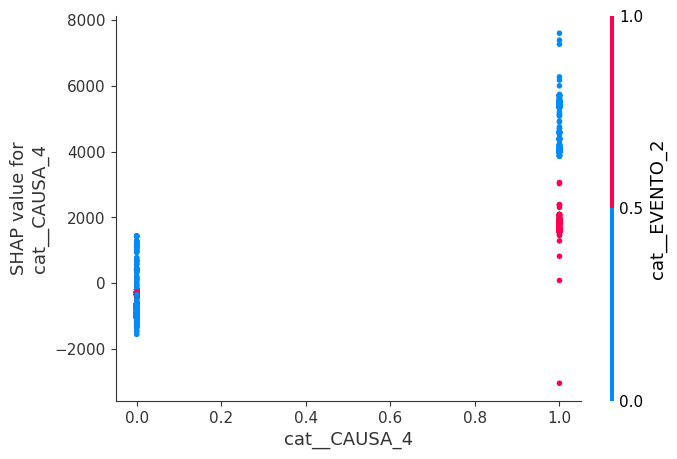

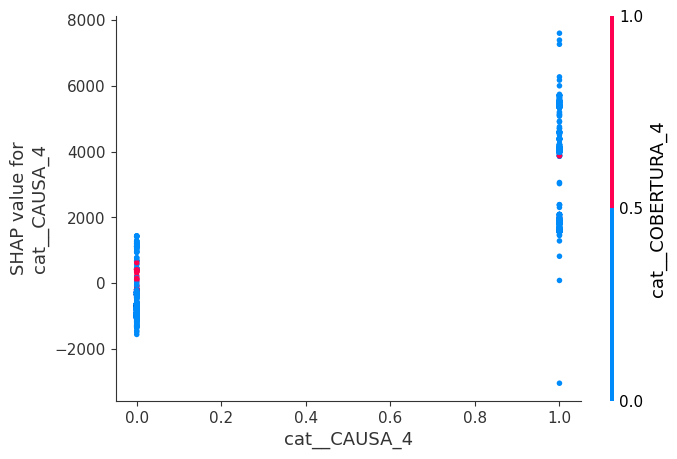

In [69]:
shap.dependence_plot(
        "cat__CAUSA_4",        # Caractéristique principale
        shap_values,            # Valeurs SHAP calculées
        X_sample,               # Données utilisées pour SHAP
        interaction_index="cat__EVENTO_2"  # Caractéristique d'interaction
    )

shap.dependence_plot(
        "cat__CAUSA_4",        # Caractéristique principale
        shap_values,            # Valeurs SHAP calculées
        X_sample,               # Données utilisées pour SHAP
        interaction_index="cat__COBERTURA_4"  # Caractéristique d'interaction
    )

# GradientBoosting

Scores MSE négatifs par pli : [-13109040.74891933 -13684436.73416242 -13296556.73655353
 -12693113.5810939  -12872970.76828764]
MSE moyen : 13131223.713803366
MAE : 1343.90
RMSE : 3570.25
R² : 0.49
MSE : 12746650.18
Déviance : 1504053734111.20
AIC : 973857.24


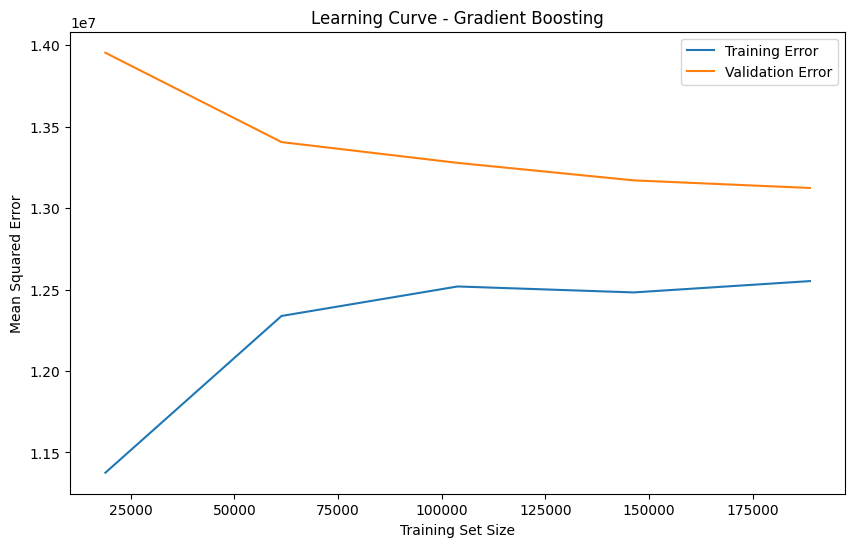

Les 10 caractéristiques les plus importantes :
           Feature  Importance
4267       CAUSA_5    0.332716
4266       CAUSA_4    0.197443
4265       CAUSA_3    0.164140
4263       CAUSA_1    0.090821
4256      EVENTO_2    0.038513
4252   COBERTURA_4    0.028138
4255      EVENTO_1    0.025236
4264       CAUSA_2    0.013207
4181  COD_TARIF_10    0.009961
4270       CAUSA_9    0.009915


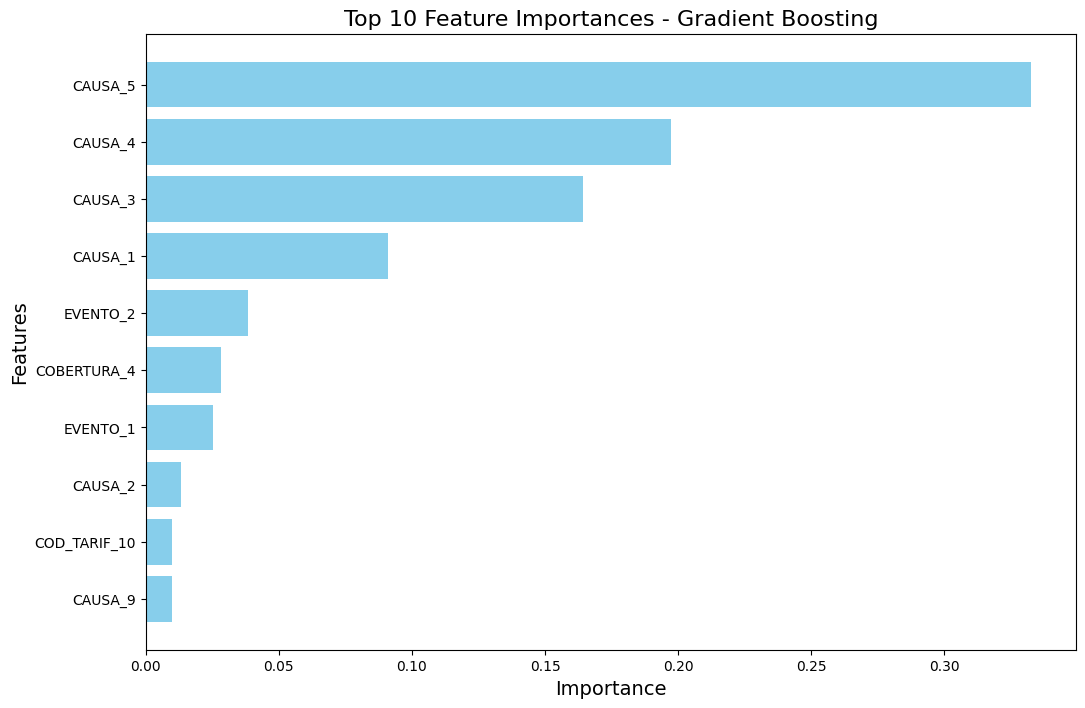

In [96]:
# Définir le transformateur pour les colonnes catégoriques
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline combiné pour les colonnes catégoriques uniquement
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_cols)  # cat_cols est la liste des colonnes catégoriques
    ]
)

# Pipeline complet avec GradientBoostingRegressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
])

# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Résultats de la validation croisée
print("Scores MSE négatifs par pli :", cv_scores)
print("MSE moyen :", -cv_scores.mean())

# Ajuster le pipeline sur l'ensemble d'entraînement
model_pipeline.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model_pipeline.predict(X_test)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Approximation de la déviance comme 2 * somme des résidus quadratiques
deviance = 2 * mse * len(y_test)

# Approximation de l'AIC
n_params = len(model_pipeline.named_steps['model'].feature_importances_)
aic = len(y_test) * np.log(mse) + 2 * n_params

# Affichage des résultats
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.2f}")
print(f"MSE : {mse:.2f}")
print(f"Déviance : {deviance:.2f}")
print(f"AIC : {aic:.2f}")

# Courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

# Moyennes des scores d'entraînement et de validation
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Visualisation de la courbe d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, test_scores_mean, label="Validation Error")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curve - Gradient Boosting")
plt.legend()
plt.show()

# Importances des caractéristiques
importances = model_pipeline.named_steps['model'].feature_importances_

# Obtenir les noms des colonnes après transformation (uniquement pour les catégoriques)
encoded_features = model_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(cat_cols)

# Vérifier si les dimensions correspondent
if len(encoded_features) == len(importances):
    feature_importances = pd.DataFrame({
        'Feature': encoded_features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Afficher les 10 caractéristiques les plus importantes
    print("Les 10 caractéristiques les plus importantes :")
    print(feature_importances.head(10))

    # Visualisation des importances
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
    plt.title('Top 10 Feature Importances - Gradient Boosting', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Erreur : Le nombre de colonnes transformées et des importances ne correspondent pas.")

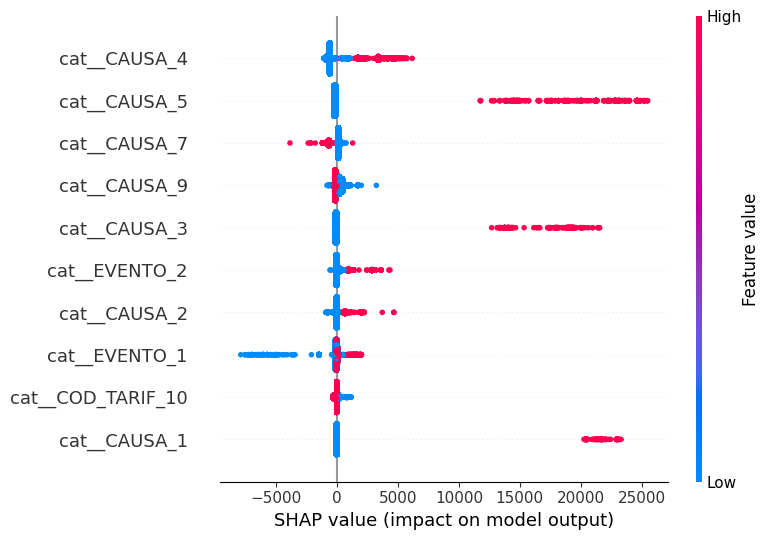

ValueError: Could not find feature named: cat__COD_MODELO_001001-4

In [ ]:
# Analyse SHAP
# Créer un échantillon des données de test transformées
X_test_transformed = model_pipeline.named_steps['preprocessor'].transform(X_test)
X_sample_transformed = pd.DataFrame.sparse.from_spmatrix(
    X_test_transformed,
    columns=model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

# Créer un explainer SHAP
explainer = shap.Explainer(model_pipeline.named_steps['model'])

# Calculer les valeurs SHAP pour l'échantillon
shap_values = explainer(X_sample_transformed)

# Afficher les noms des colonnes après transformation
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Créer un DataFrame pour mapper les SHAP values avec les colonnes
X_sample_transformed_df = pd.DataFrame(X_sample_transformed, columns=feature_names)

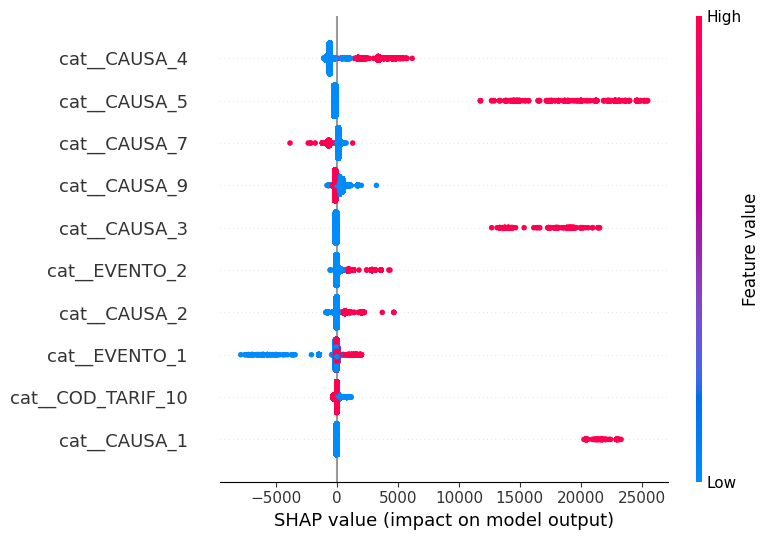

In [103]:
# SHAP Summary Plot
shap.summary_plot(shap_values.values, X_sample_transformed_df, feature_names=feature_names, max_display=10)

# GLM

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Initialiser un modèle de régression linéaire
model = LinearRegression()

# Entraîner le modèle
model.fit(X_train_transformed, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test_transformed)

# Calcul des métriques
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Approximation de l'AIC
n_params = X_train_transformed.shape[1] + 1  # Nombre de paramètres (inclut l'intercept)
aic = len(y_test) * np.log(mse) + 2 * n_params

# Afficher les résultats
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"AIC: {aic:.2f}")

Mean Absolute Error (MAE): 2609.70
Mean Squared Error (MSE): 25288859.20
Root Mean Squared Error (RMSE): 5028.80
R² Score: 0.02
AIC: 1571265.22


In [77]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
df_positive_sample = df[df['INDENIZ'] > 0]
# Préparer la formule du modèle GLM
formula_glm = 'INDENIZ ~   COBERTURA + AGE + ANO_MODELO + COD_TARIF + REGIAO + SEXO + EVENTO + CAUSA'

# Ajuster le modèle GLM
glm_model = smf.glm(formula=formula_glm, 
                    data=df_positive_sample, 
                    family=sm.families.Gamma(link=sm.families.links.log()))
glm_results = glm_model.fit()

# ---- Insérer le correctif ici ----
# Si X_test_transformed est une matrice sparse, la convertir en dense
X_test_dense = X_test_transformed.toarray() if hasattr(X_test_transformed, "toarray") else X_test_transformed

# Effectuer les prédictions
y_pred = glm_results.predict(X_test_dense)

# Calcul des métriques
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Afficher les métriques
print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R² : {r2:.2f}")


MemoryError: Unable to allocate 18.6 GiB for an array with shape (89905, 27730) and data type float64